In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.signal import find_peaks, argrelextrema
from gapstatistics.gapstatistics import GapStatistics
import seaborn as sns

In [47]:
# Set seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

In [66]:

# Define a class to encapsulate the EDA and Clustering process
class SpermWhaleEDA:
    def __init__(self, file_path, clan=None, tempo_range=(0.1, 1.75), duration_col_name='Duration', clan_col_name='Clan'):
        """
        Initialize the EDA class with dataset path, clan filter, and tempo range.
        
        Parameters:
        - file_path (str): Path to the CSV or Excel file.
        - clan (str): Clan label to filter (default: 'EC1').
        - tempo_range (tuple): Tuple indicating the (min, max) tempo to filter.
        """
        self.duration_col_name = duration_col_name
        self.clan_col_name = clan_col_name
        
        self.file_path = file_path
        self.clan = clan
        self.tempo_min, self.tempo_max = tempo_range
        self.df, self.headers = self.read_data()
        self.all_tempos = self.filter_tempos()
        self.kde = None
        self.kde_bandwidth = 0.035  # Default bandwidth
        self.kde_s = None
        self.kde_density = None
        self.gmm = None
        self.kmeans = None
        self.agg_clustering = None
        self.intervals = {}
        self.gap_statistics = None  # To store GapStatistics object
        self.gap_params = None      # To store params from GapStatistics
        

    def read_data(self):
        """
        Read data from CSV or Excel file and drop unnecessary columns.
        
        Returns:
        - df (DataFrame): Filtered DataFrame.
        - headers (list): List of column headers.
        """
        if self.file_path.endswith('.xlsx'):
            df = pd.read_excel(self.file_path)
        elif self.file_path.endswith('.csv'):
            df = pd.read_csv(self.file_path)
        else:
            raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")
        
        columns_to_drop = ['Date', 'CodaType', 'Unit', 'UnitNum', 'IDN']
        df = df.drop(columns=columns_to_drop, axis=1, errors='ignore')
        headers = df.columns.values
        return df, headers

    def filter_tempos(self):
        """
        Filter tempos based on clan and tempo range.
        
        Returns:
        - filtered_tempos (list): List of filtered tempo values.
        """
        # Ensure 'Clan' and 'Duration' columns exist
        if self.clan_col_name not in self.df.columns or self.duration_col_name not in self.df.columns:
            raise ValueError(f"Required columns '{self.clan_col_name}' and '{self.duration_col_name}' not found in the dataset.")
        
        # Filter by clan
        df_clan = self.df
        if self.clan != None:
            df_clan = self.df[self.df[self.clan_col_name] == self.clan]
        
        # Filter by tempo range
        filtered_df = df_clan[(df_clan[self.duration_col_name].astype(float) > self.tempo_min) & 
                              (df_clan[self.duration_col_name].astype(float) < self.tempo_max)]
        
        filtered_tempos = filtered_df[self.duration_col_name].astype(float).tolist()
        if self.clan == None:
            print(f"Number of codas: {len(filtered_tempos)}")
        else:
            print(f"Number of codas from the {self.clan} clan: {len(filtered_tempos)}")
        return filtered_tempos

    def plot_histogram(self, bins=300, title='Histogram of Tempos'):
        """
        Plot a histogram of the filtered tempos.
        
        Parameters:
        - bins (int): Number of histogram bins.
        - title (str): Title of the plot.
        """
        plt.figure(figsize=(10, 6))
        plt.hist(self.all_tempos, bins=bins, color='skyblue', edgecolor='black')
        plt.title(title)
        plt.xlabel('Tempo')
        plt.ylabel('Counts')
        plt.show()

    def perform_kde(self, bandwidth=0.035):
        """
        Perform Kernel Density Estimation on the tempos.
        
        Parameters:
        - bandwidth (float): Bandwidth for KDE.
        """
        self.kde_bandwidth = bandwidth
        a = np.array(self.all_tempos).reshape(-1, 1)
        self.kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(a)
        self.kde_s = np.linspace(self.tempo_min, self.tempo_max, 1000).reshape(-1, 1)
        self.kde_density = self.kde.score_samples(self.kde_s)

    def plot_kde(self, title='Kernel Density Estimation'):
        """
        Plot the KDE result.
        
        Parameters:
        - title (str): Title of the plot.
        """
        if self.kde_density is None:
            raise ValueError("KDE not performed yet. Call perform_kde() first.")
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.kde_s, self.kde_density, color='red')
        plt.title(title)
        plt.xlabel('Tempo')
        plt.ylabel('Log Density')
        plt.show()

    def find_kde_extrema(self):
        """
        Find local minima and maxima in the KDE density.
        
        Returns:
        - minima (np.array): Array of tempo values at local minima.
        - maxima (np.array): Array of tempo values at local maxima.
        """
        if self.kde_density is None:
            raise ValueError("KDE not performed yet. Call perform_kde() first.")
        
        # Find local minima and maxima
        mi = argrelextrema(self.kde_density, np.less)[0]
        ma = argrelextrema(self.kde_density, np.greater)[0]
        
        minima = self.kde_s[mi].flatten()
        maxima = self.kde_s[ma].flatten()
        
        print("Minima:", minima)
        print("Maxima:", maxima)
        
        return minima, maxima

    def plot_kde_with_extrema(self, minima, maxima):
        """
        Plot KDE with marked minima and maxima.
        
        Parameters:
        - minima (np.array): Tempo values at local minima.
        - maxima (np.array): Tempo values at local maxima.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.kde_s, self.kde_density, color='red', label='KDE Density')
        plt.scatter(minima, self.kde.score_samples(minima.reshape(-1, 1)), color='green', marker='o', label='Minima')
        plt.scatter(maxima, self.kde.score_samples(maxima.reshape(-1, 1)), color='black', marker='x', label='Maxima')
        plt.title('KDE with Minima and Maxima')
        plt.xlabel('Tempo')
        plt.ylabel('Log Density')
        plt.legend()
        plt.show()

    def plot_interval_clustering(self, intervals, title='Clustering Intervals'):
        """
        Plot histogram segments based on 
        .
        
        Parameters:
        - intervals (list): List of interval boundaries.
        - title (str): Title of the plot.
        """
        # Extend intervals to cover the entire range
        extended_intervals = [self.tempo_min, *intervals, self.tempo_max]
        colors = ['red', 'green', 'blue', 'yellow', 'orange', 'violet', 'brown', 'pink']
        
        plt.figure(figsize=(12, 7))
        for i in range(len(extended_intervals) - 1):
            interval_data = [tempo for tempo in self.all_tempos 
                             if extended_intervals[i] <= tempo < extended_intervals[i + 1]]
            plt.hist(interval_data, bins=100, color=colors[i % len(colors)], alpha=0.6, 
                     label=f"{extended_intervals[i]:.2f} - {extended_intervals[i+1]:.2f}")
        
        plt.title(title)
        plt.xlabel('Tempo')
        plt.ylabel('Counts')
        plt.legend(title="Tempo Intervals")
        plt.show()

    def cluster_data(self, method='GMM', n_clusters=5):
        """
        Apply clustering to the data using the specified method.
        
        Parameters:
        - method (str): Clustering method ('GMM', 'KMeans', 'Agglomerative').
        - n_clusters (int): Number of clusters.
        
        Returns:
        - labels (np.array): Cluster labels for each data point.
        """
        data = np.array(self.all_tempos).reshape(-1, 1)
        
        if method == 'GMM':
            self.gmm = GaussianMixture(n_components=n_clusters, random_state=0).fit(data)
            labels = self.gmm.predict(data)
        
        elif method == 'KMeans':
            self.kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
            labels = self.kmeans.labels_
        
        elif method == 'Agglomerative':
            self.agg_clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(data)
            labels = self.agg_clustering.labels_
        
        else:
            raise ValueError("Unsupported clustering method. Choose from 'GMM', 'KMeans', 'Agglomerative'.")
        
        # Calculate Silhouette Score
        score = silhouette_score(data, labels)
        print(f"Silhouette Score for {method} with {n_clusters} clusters: {score:.3f}")
        
        return labels

    def determine_optimal_clusters_gap(self, K_max=10, K_min=2):
        """
        Use Gap Statistics to determine the optimal number of clusters.
        
        Parameters:
        - K_max (int): Maximum number of clusters to consider.
        - K_min (int): Minimum number of clusters to consider.
        
        Returns:
        - optimal_k (int): Optimal number of clusters.
        """
        data = np.array(self.all_tempos).reshape(-1, 1)
        
        # Since GapStatistics expects 2D data, duplicate the single feature
        data_for_gap = np.hstack([data, np.zeros_like(data)])
        
        # Initialize GapStatistics with desired parameters
        gs = GapStatistics(distance_metric='minkowski', return_params=True)
        
        # Perform Gap Statistics
        optimal_k, params = gs.fit_predict(K=K_max, X=data_for_gap, n_iterations=30)
        
        # Extract gap values and reference dispersions for computing s_k
        if isinstance(params, dict):
            if 'gaps' in params and 'Wks' in params and 'sim_Wks' in params and 'sim_sks' in params:
                gaps = params['gaps']
                sim_Wks = params['sim_Wks']
                sim_sks = params['sim_sks']  # s_k values provided in params
                cluster_counts = list(range(1, K_max + 1))
            else:
                raise KeyError("Expected keys 'gaps', 'Wks', 'sim_Wks', 'sim_sks' in params.")
        else:
            raise TypeError("Unexpected type for params. Expected dict.")
        
        # Exclude k values below K_min
        gaps = gaps[K_min-1:K_max]
        cluster_counts = list(range(K_min, K_max + 1))
        s_k = sim_sks[K_min-1:K_max]  # Use the corresponding subset of s_k values
        
        # Apply the selection criteria manually
        for i in range(len(cluster_counts) - 1):
            if gaps[i] >= gaps[i+1] - s_k[i+1]:
                optimal_k = cluster_counts[i]
                break
        else:
            optimal_k = cluster_counts[-1]
        
        print(f'Adjusted optimal number of clusters according to Gap Statistic: {optimal_k}')
        
        # Plot Gap Statistic
        plt.figure(figsize=(10, 6))
        plt.plot(cluster_counts, gaps, marker='o')
        plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K = {optimal_k}')
        plt.title('Gap Statistic by Number of Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Gap Statistic')
        plt.legend()
        plt.show()
        
        return optimal_k

    
    def extract_interval_boundaries(self, cluster_centers):
        """
        Extract interval boundaries based on sorted cluster centers.
        
        Parameters:
        - cluster_centers (np.array): Sorted cluster centers.
        
        Returns:
        - boundaries (list): List of boundary points.
        """
        sorted_centers = np.sort(cluster_centers)
        boundaries = [(sorted_centers[i] + sorted_centers[i+1]) / 2 for i in range(len(sorted_centers) - 1)]
        return boundaries

    def visualize_clusters(self, labels, method='GMM', title='Clustering Visualization'):
        """
        Visualize the clustering results over the histogram.
        
        Parameters:
        - labels (np.array): Cluster labels.
        - method (str): Clustering method name.
        - title (str): Title of the plot.
        """
        plt.figure(figsize=(12, 7))
        sns.histplot(self.all_tempos, bins=100, kde=False, color='lightgrey', label='Data', stat='density')
        
        if method == 'GMM' and self.gmm is not None:
            x = np.linspace(self.tempo_min, self.tempo_max, 1000).reshape(-1, 1)
            log_dens = self.gmm.score_samples(x)
            plt.plot(x, np.exp(log_dens), color='blue', label='GMM Density')
            centers = np.sort(self.gmm.means_.flatten())
            for center in centers:
                plt.axvline(x=center, color='blue', linestyle='--', alpha=0.5, label='GMM Centers' if center == centers[0] else "")
        
        elif method == 'KMeans' and self.kmeans is not None:
            centers = np.sort(self.kmeans.cluster_centers_.flatten())
            for center in centers:
                plt.axvline(x=center, color='green', linestyle='--', alpha=0.5, label='K-Means Centers' if center == centers[0] else "")
        
        elif method == 'Agglomerative' and self.agg_clustering is not None:
            labels_unique = np.unique(self.agg_clustering.labels_)
            centers = []
            for i in labels_unique:
                cluster_data = np.array(self.all_tempos)[self.agg_clustering.labels_ == i]
                if len(cluster_data) > 0:
                    centers.append(np.mean(cluster_data))
            centers = np.sort(centers)
            for center in centers:
                plt.axvline(x=center, color='red', linestyle=':', alpha=0.5, 
                            label='Agglomerative Centers' if center == centers[0] else "")
                        
        plt.title(title)
        plt.xlabel('Tempo')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    def run_full_eda(self, bandwidth=0.035, K_max=10, clustering_methods=['GMM', 'KMeans', 'Agglomerative']):
        """
        Run the complete EDA and clustering pipeline.
        
        Parameters:
        - bandwidth (float): Bandwidth for KDE.
        - K_max (int): Maximum number of clusters for Gap Statistics.
        - clustering_methods (list): List of clustering methods to apply.
        """
        # Plot Histogram
        self.plot_histogram(title='Histogram of EC1 Clan Tempos')
        
        # Perform and Plot KDE
        self.perform_kde(bandwidth=bandwidth)
        self.plot_kde(title='Kernel Density Estimation of Tempos')
        
        # Find and Plot Extrema
        minima, maxima = self.find_kde_extrema()
        self.plot_kde_with_extrema(minima, maxima)
        
        # Plot Clustering Intervals
        self.plot_interval_clustering(minima, 
            title=f'Histogram with KDE Clustering Intervals')
        
        # Determine Optimal Clusters using Gap Statistics
        optimal_k = self.determine_optimal_clusters_gap(K_max=K_max)
        
        # Apply Clustering Methods
        for method in clustering_methods:
            print(f"\nApplying {method} Clustering with {optimal_k} clusters...")
            labels = self.cluster_data(method=method, n_clusters=optimal_k)
            self.visualize_clusters(labels, method=method, 
                                    title=f'{method} Clustering with {optimal_k} Clusters')
            # Extract Interval Boundaries
            if method == 'GMM' and self.gmm is not None:
                centers = self.gmm.means_.flatten()
            elif method == 'KMeans' and self.kmeans is not None:
                centers = self.kmeans.cluster_centers_.flatten()
            elif method == 'Agglomerative' and self.agg_clustering is not None:
                # Iterate over each unique cluster label to compute the mean of each cluster
                labels_unique = np.unique(self.agg_clustering.labels_)
                centers = []
                for label in labels_unique:
                    # Select data points in the current cluster
                    cluster_data = np.array(self.all_tempos)[self.agg_clustering.labels_ == label]
                    if len(cluster_data) > 0:  # Ensure the cluster is not empty
                        centers.append(np.mean(cluster_data))
                centers = np.sort(centers)  # Sort the centers for consistent interval boundaries
            else:
                continue
            
            intervals = self.extract_interval_boundaries(centers)
            self.intervals[method] = intervals
            print(f"{method} Interval Boundaries:", intervals)
            
            # Plot Clustering Intervals
            self.plot_interval_clustering(intervals, 
                                         title=f'Histogram with {method} Clustering Intervals')

    def predict_new_data(self, new_data, method='GMM'):
        """
        Predict cluster labels for new data points using the specified clustering method.
        
        Parameters:
        - new_data (list or np.array): New tempo values to classify.
        - method (str): Clustering method used for prediction ('GMM', 'KMeans', 'Agglomerative').
        
        Returns:
        - new_labels (np.array): Predicted cluster labels for the new data.
        """
        new_data = np.array(new_data).reshape(-1, 1)
        
        if method == 'GMM' and self.gmm is not None:
            new_labels = self.gmm.predict(new_data)
        
        elif method == 'KMeans' and self.kmeans is not None:
            new_labels = self.kmeans.predict(new_data)
        
        elif method == 'Agglomerative' and self.agg_clustering is not None:
            # Use Nearest Centroid approach for Agglomerative Clustering
            centers = np.array([data.mean() for data in np.array(self.all_tempos)[self.agg_clustering.labels_ == i]]).flatten().reshape(-1, 1)
            from sklearn.neighbors import NearestCentroid
            centroid_clf = NearestCentroid()
            centroid_clf.fit(centers, range(len(centers)))
            new_labels = centroid_clf.predict(new_data)
        
        else:
            raise ValueError("Unsupported method or method not fitted yet.")
        
        return new_labels

    def save_model(self, method, filename):
        """
        Save the trained clustering model to a file.
        
        Parameters:
        - method (str): Clustering method ('GMM', 'KMeans', 'Agglomerative').
        - filename (str): Path to save the model.
        """
        import joblib
        if method == 'GMM' and self.gmm is not None:
            joblib.dump(self.gmm, filename)
        elif method == 'KMeans' and self.kmeans is not None:
            joblib.dump(self.kmeans, filename)
        elif method == 'Agglomerative' and self.agg_clustering is not None:
            joblib.dump(self.agg_clustering, filename)
        else:
            raise ValueError("Unsupported method or model not trained yet.")

    def load_model(self, method, filename):
        """
        Load a trained clustering model from a file.
        
        Parameters:
        - method (str): Clustering method ('GMM', 'KMeans', 'Agglomerative').
        - filename (str): Path to load the model from.
        """
        import joblib
        if method == 'GMM':
            self.gmm = joblib.load(filename)
        elif method == 'KMeans':
            self.kmeans = joblib.load(filename)
        elif method == 'Agglomerative':
            self.agg_clustering = joblib.load(filename)
        else:
            raise ValueError("Unsupported method.")

In [67]:
file_path = "../../../data/etp-bermant.csv"  # Update the path as needed

In [68]:
eda = SpermWhaleEDA(file_path=file_path, tempo_range=(0.1, 1.75), clan='Regular', duration_col_name='TotalDur', clan_col_name='ClanName')

Number of codas from the Regular clan: 6306


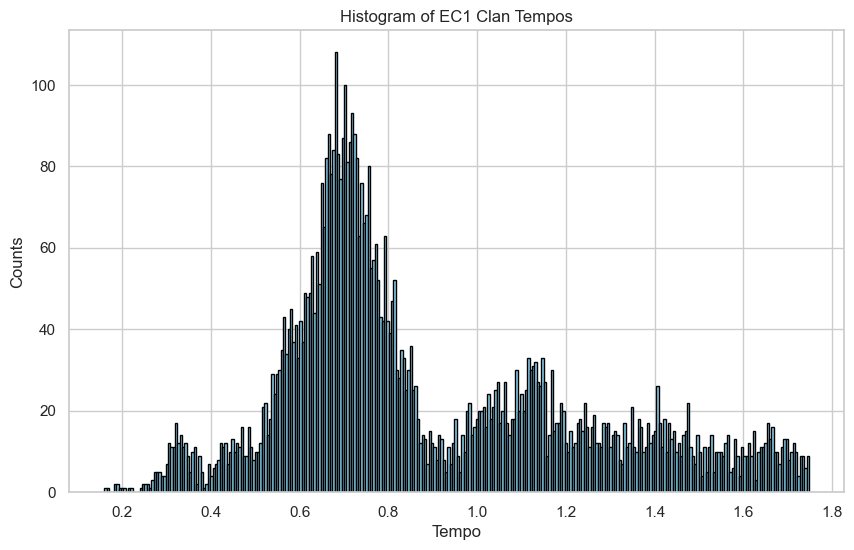

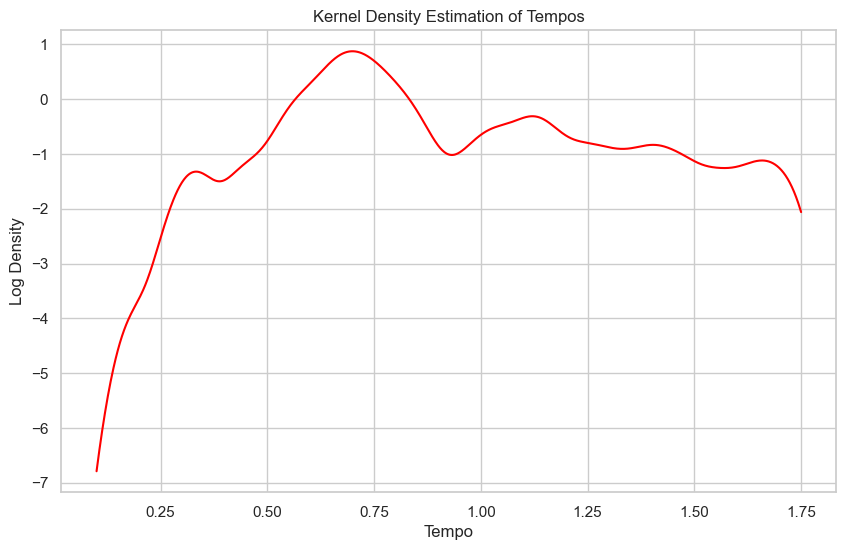

Minima: [0.38738739 0.93243243 1.33213213 1.56996997]
Maxima: [0.33288288 0.69954955 1.12072072 1.40315315 1.65915916]


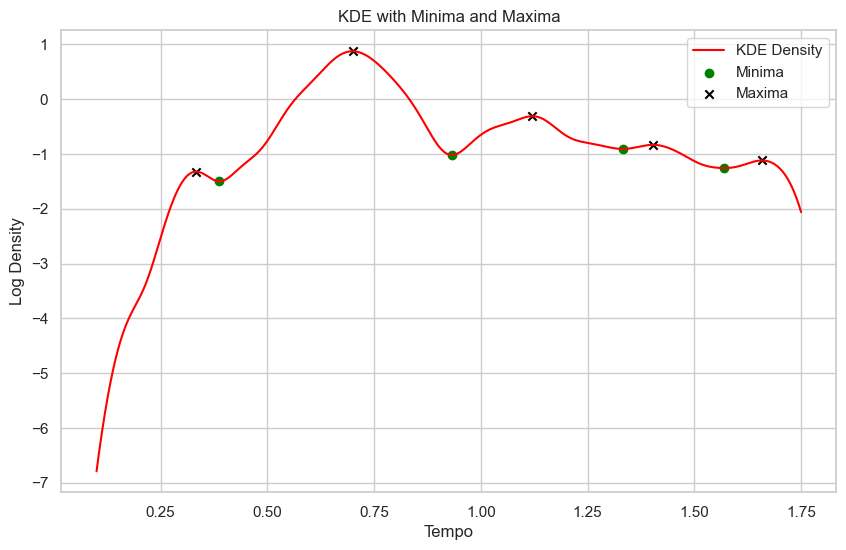

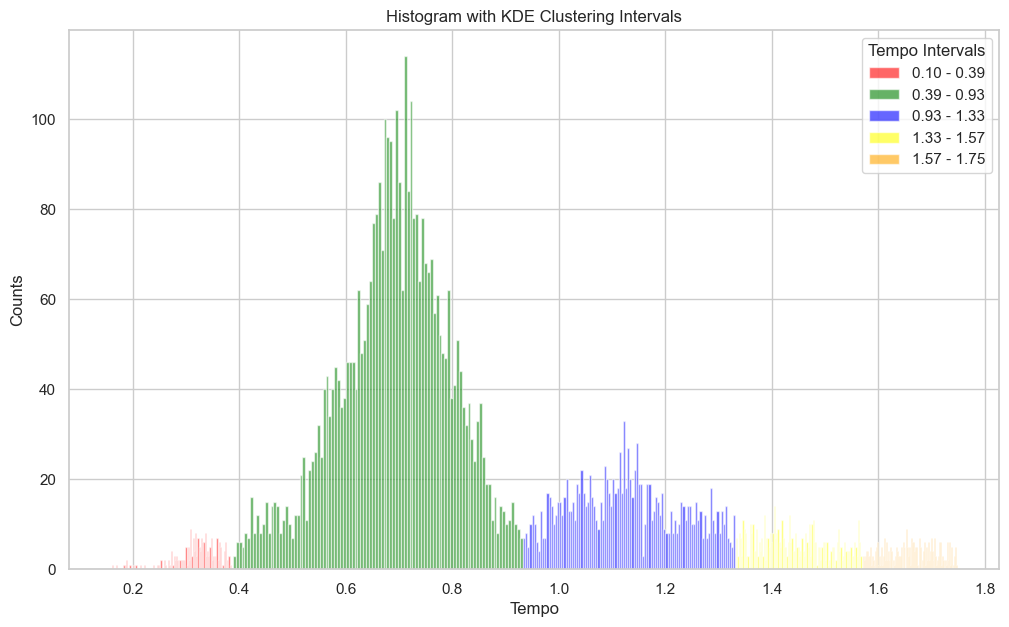

Adjusted optimal number of clusters according to Gap Statistic: 6


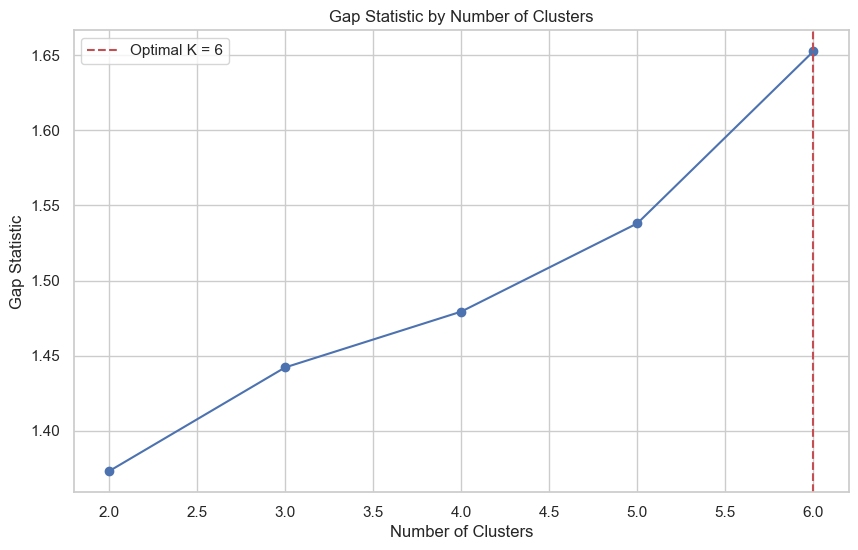


Applying GMM Clustering with 6 clusters...
Silhouette Score for GMM with 6 clusters: 0.537


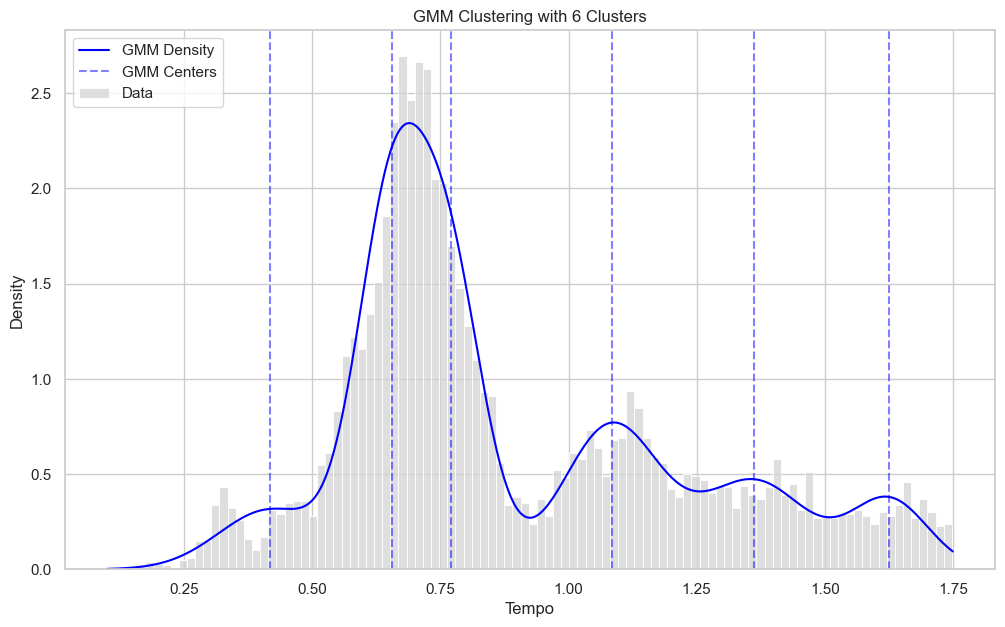

GMM Interval Boundaries: [np.float64(0.5366843637780938), np.float64(0.7128251055670201), np.float64(0.9275521992418239), np.float64(1.2239174413131584), np.float64(1.4940211379261434)]


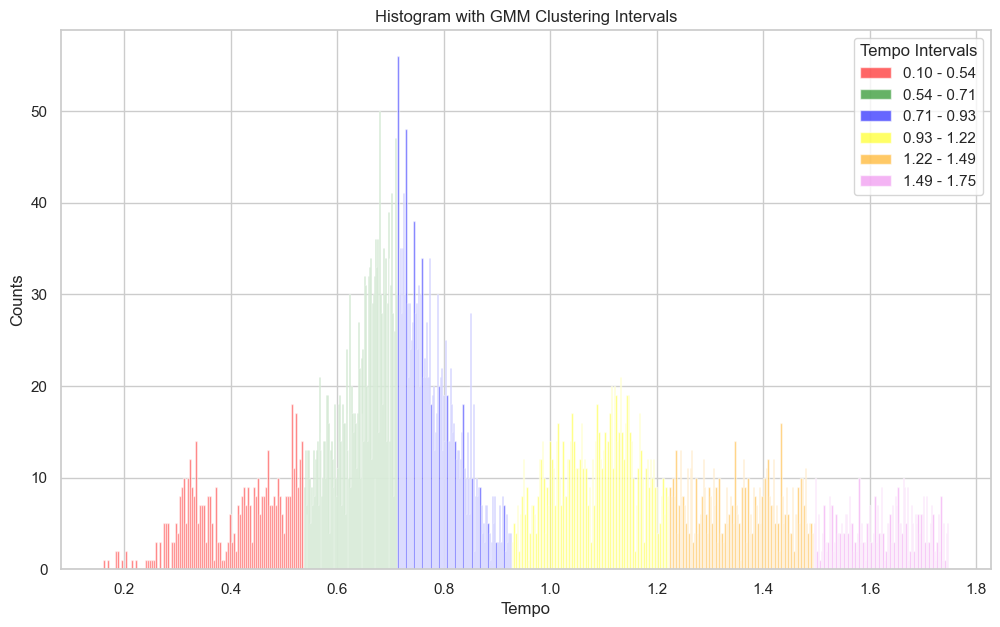


Applying KMeans Clustering with 6 clusters...
Silhouette Score for KMeans with 6 clusters: 0.543


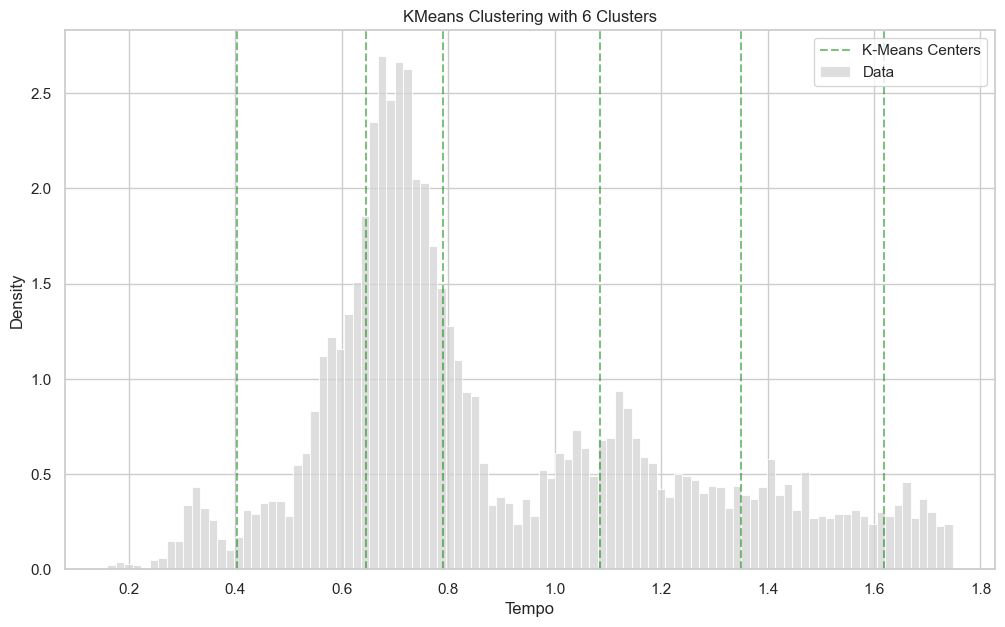

KMeans Interval Boundaries: [np.float64(0.5251078650671862), np.float64(0.7178568135125909), np.float64(0.9377273141182989), np.float64(1.2177295272674575), np.float64(1.4840489091967664)]


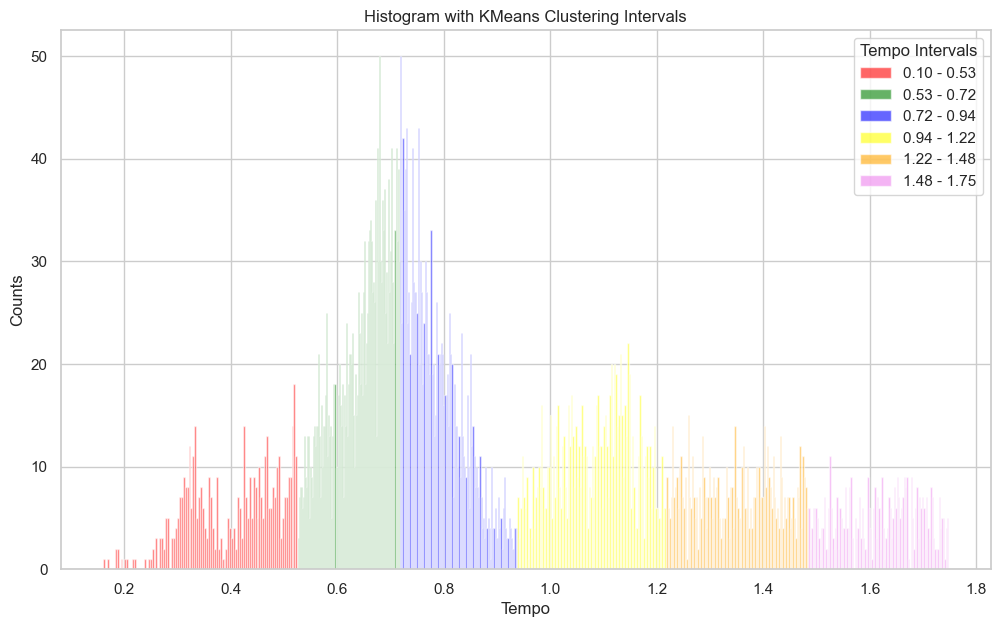


Applying Agglomerative Clustering with 6 clusters...
Silhouette Score for Agglomerative with 6 clusters: 0.499


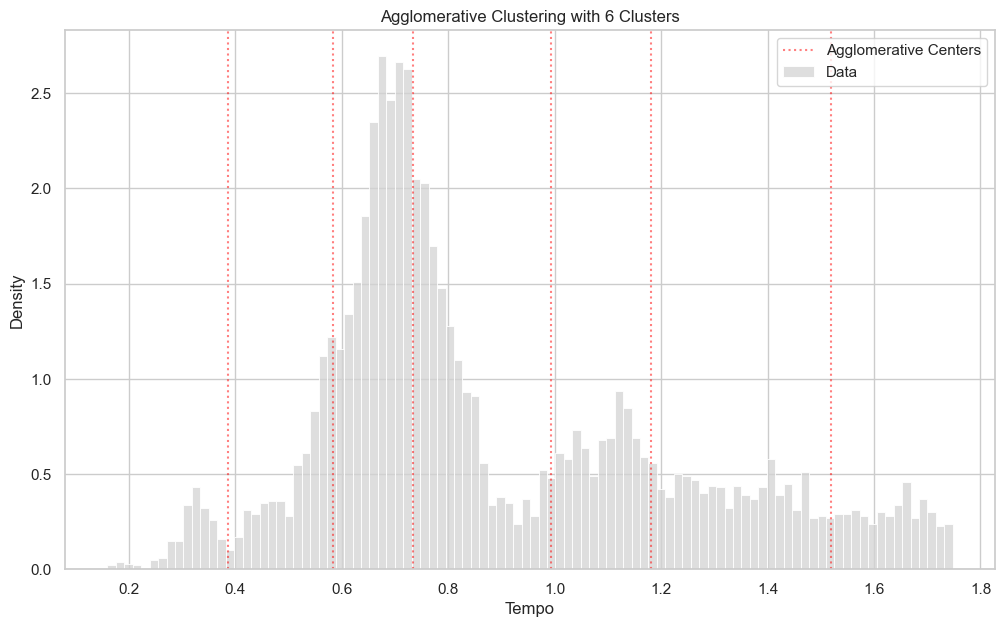

Agglomerative Interval Boundaries: [np.float64(0.4848998228206941), np.float64(0.6588569820212946), np.float64(0.8641098416494344), np.float64(1.087846604264041), np.float64(1.3504698254296645)]


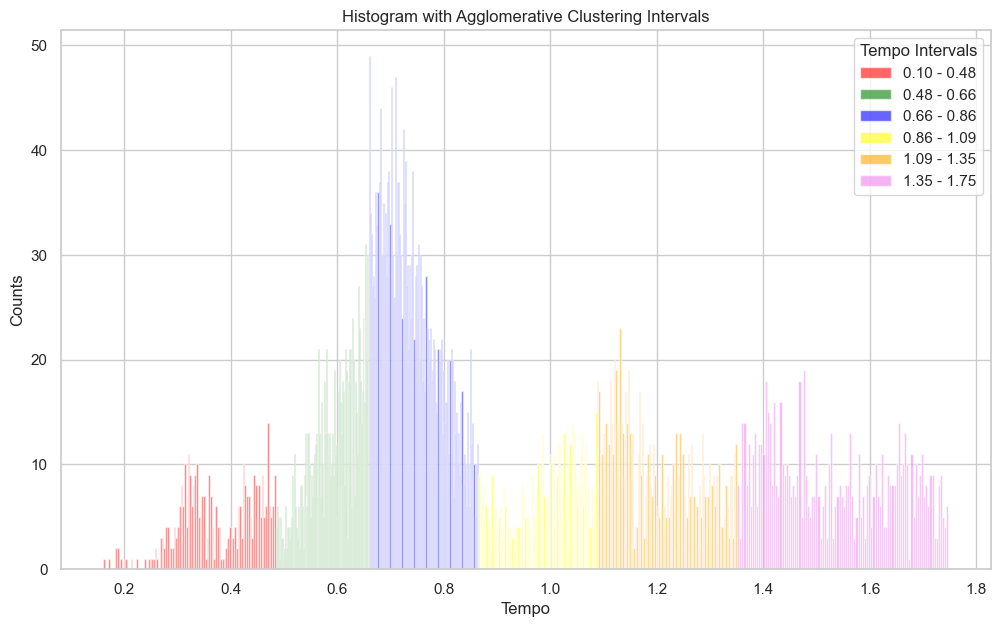

In [70]:
# Run the full EDA and Clustering pipeline
eda.run_full_eda(bandwidth=0.035, K_max=6, 
                clustering_methods=['GMM', 'KMeans', 'Agglomerative'])

In [52]:
# Predict cluster labels for new data points
new_tempos = [0.5, 1.2, 1.8]  # Example new tempo values
method = 'KMeans'  # Choose from 'GMM', 'KMeans', 'Agglomerative'
predicted_labels = eda.predict_new_data(new_tempos, method=method)
print(f"Predicted Labels for New Data ({method}):", predicted_labels)

Predicted Labels for New Data (KMeans): [3 2 4]


In [53]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(self, labels):
    """
    Evaluate clustering performance using various metrics.
    
    Parameters:
    - labels (np.array): Cluster labels.
    """
    data = np.array(self.all_tempos_ec1).reshape(-1, 1)
    silhouette = silhouette_score(data, labels)
    ch_score = calinski_harabasz_score(data, labels)
    db_score = davies_bouldin_score(data, labels)
    
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {ch_score:.3f}")
    print(f"Davies-Bouldin Index: {db_score:.3f}")